In [4]:
import numpy as np 
from scipy import stats
from scipy.stats import pearsonr,spearmanr
from numpy.linalg import norm,eig
from astropy.io import ascii
import matplotlib.pyplot as plt
from sympy import rsolve

In [2]:
def transform(v1,v2,axis = None):
    #convert to coords of principal axis (v2)
    #Take transpose so that v1[0],v1[1],v1[2] are all x,y,z respectively
    v1 = v1.T
    v_new = np.zeros(np.shape(v1))
    #loop over each of the 3 coorinates
    if axis == None:
        for i in range(3):
            v_new[i] += v1[0]*v2[i,0]+v1[1]*v2[i,1]+v1[2]*v2[i,2]
        return v_new
    else:
        v_new[0] += v1[0]*v2[axis,0]+v1[1]*v2[axis,1]+v1[2]*v2[axis,2]
        return v_new

def get_eigs(I,rvir):
    #return eigenvectors and eigenvalues
    w,v = eig(I)
    #sort in descending order
    odr = np.argsort(-1.*w)
    #sqrt of e values = a,b,c
    w = np.sqrt(w[odr])
    v = v.T[odr]
    #rescale so major axis = radius of original host
    ratio = rvir/w[0]
    w[0] = w[0]*ratio #this one is 'a'
    w[1] = w[1]*ratio #b
    w[2] = w[2]*ratio #c

    return w,v


def get_radii(sub_pos,host_e_vects):
    new_pos = transform(sub_pos,host_e_vects).T

    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    #p = np.zeros(len(new_pos))
    #t = np.zeros(len(new_pos))
       
    hA = host_e_vects[0]
    hA2 = np.repeat(hA,len(new_pos)).reshape(3,len(new_pos)).T
    hB = host_e_vects[1]
    #hB2 = np.repeat(hB,len(new_pos)).reshape(3,len(new_pos)).T
    #hC = host_e_vects[2]

    para1 = (new_pos*hA2/norm(hA)).sum(axis=1)
    para2 = (hA/norm(hA)).T
    para = np.array((para2[0]*para1,para2[1]*para1,para2[2]*para1))
    perp = new_pos-para.T

    r = np.sqrt(np.sum(perp**2,axis=1))

    return r

def get_density_profile(rs):
    #create pdf for halo mass function
    bins = np.linspace(min((rs)),max((rs)),25)
    hist = np.histogram(rs,bins)
    hist_dist = stats.rv_histogram(hist)

    return hist_dist

def get_mass_function(mvirs):
    #create pdf for halo mass function
    bins = np.logspace(min(np.log10(mvirs)),max(np.log10(mvirs)),25)
    hist = np.histogram(mvirs,bins)
    hist_dist = stats.rv_histogram(hist)

    return hist_dist

def get_samples(arr,pdf,num_samples = 100):
    #samples = [choice(arr) for _ in range(num_samples)]
    samples = np.random.choice(arr, num_samples, replace=True, p=pdf/np.sum(pdf))

    return samples

def MC_err(n, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0):

    prsnr = np.zeros(n_rep)
    for i in range(n_rep):
        pdfs1 = val_min1 + np.random.random(n)*val_max1
        pdfs2 = val_min2 + np.random.random(n)*val_max2
        prsnr[i]+=stats.pearsonr(pdfs1,pdfs2)[0]
    err = np.std(prsnr)
        
    return err

In [10]:
#for hlist
names =['scale','ID','desc_scale','desc_id','num_prog','pid','upid','desc_pid',
    'phantom','sam_mvir','Mvir','Rvir','Rs', 'vrms', 'mmp', 'scale_of_last_MM',
    'Vmax', 'X','Y','Z','VX','VY','VZ','JX','JY','JZ','Spin','Breadth_first_ID',
    'Depth_first_ID','Tree_root_ID','Orig_halo_ID','Snap_num',
    'Next_coprogenitor_depthfirst_ID','Last_progenitor_depthfirst_ID',
    'Rs_Klypin','Mvir_all','M200b','M200c','M500c','M2500c','Xoff','Voff',
    'spin_bullock','b_to_a','c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)',
    'c_to_a(500c)','A[x](500c)','A[y](500c)','A[z](500c)','T/|U|','Macc',
    'Mpeak','Vacc','Vpeak','Halfmass_Scale','Acc_Rate_Inst','Acc_Rate_100Myr',
    'Acc_Rate_Tdyn']

host_vals = ascii.read('host_og_vals.table', format = 'commented_header') 

rvirs = host_vals['rvir']
mvirs = host_vals['mvir']
hostx = host_vals['hostx']
hosty = host_vals['hosty']
hostz = host_vals['hostz']
hostvx = host_vals['hostvx']
hostvy =host_vals['hostvy']
hostvz = host_vals['hostvz']
host_shapes = host_vals['host_shapes']
host_spins = host_vals['host_spins']
host_cs = host_vals['host_cs']
hostJx = host_vals['hostJx']
hostJy = host_vals['hostJy']
hostJz = host_vals['hostJz']

halo_names = []
host_ids = []

with open('hlist_halo_ids.txt') as f:
    for l in f:
        j = 0
        this_halo, host_id = l.split()#, block, _ = l.split()
        halo_names.append(this_halo)
        host_ids.append(host_id)
        j+=1

host_I = np.load('mwm_host_inertia_tensor_no_norm.npy')

rad_cuts = [0.5]#,0.4,0.3,0.2,0.1,0.05,0.025,0.02]
n = 2
mass_frac_A = np.zeros((len(rad_cuts),int(len(halo_names)*n)))

In [303]:
halo_names_1 = [halo_names[0]]

In [309]:
for j in range(len(rad_cuts)):
    i = 0
    k = 0
    print(rad_cuts[k])
    for halo in halo_names_1:
        print(halo)
        hostvalues = ascii.read('/Users/lmezini/proj_2/rs_files/Halo{}/hlist.list'.format(halo),names=names)
        loc = int(np.where(hostvalues['ID']==int(host_ids[i]))[0][0])
        if type(loc)==int:
            halo_rvir = hostvalues['Rvir'][loc]
            halo_mvir = hostvalues['Mvir'][loc]
            host_x = hostvalues['X'][loc]
            host_y = hostvalues['Y'][loc]
            host_z = hostvalues['Z'][loc]

            mvirs[i] = halo_mvir
            rvirs[i] = halo_rvir

            hostvalues.remove_row(loc)
            
            whlimit = np.where(hostvalues['upid']==int(host_ids[i]))
            subs = hostvalues[whlimit]
            whlimit = np.where(subs['Vmax']>10.)
            subs = subs[whlimit]

            dist = np.sqrt((subs['X']-host_x)**2+(subs['Y']-host_y)**2+(subs['Z']-host_z)**2)
            whlimit = np.where(dist<halo_rvir*0.001)
    
            subs = subs[whlimit]
            del dist
            pos = np.array(((subs['X']-host_x),(subs['Y']-host_y),(subs['Z']-host_z)))
            hw, hv = get_eigs(host_I[i],rvirs[i])
            rs = get_radii(pos.T,hv)

            """
            mass_arr = np.logspace(np.log10(min(subs['Mvir'])),np.log10(max(subs['Mvir'])),len(subs))
            mass_pdf = get_mass_function((subs['Mvir'])).pdf(mass_arr)
            #plt.plot(get_mass_function(np.log10(subs['Mvir'])).pdf(np.logspace(np.log10(min(subs['Mvir'])),np.log10(max(subs['Mvir'])),20)))
            #plt.show()


            rs_arr = np.linspace((min(rs)),(max(rs)),len(mass_arr))
            rad_pdf = get_density_profile(rs).pdf(rs_arr)

            
            corr, _ = pearsonr(np.log10(subs['Mvir']),rs)
            print('Pearsons correlation: %.3f' % corr)

            corr, _ = spearmanr(np.log10(subs['Mvir']),rs)
            print('Spearmans correlation: %.3f' % corr)

            pr_err = MC_err(len(rs),2500,min(np.log10(subs['Mvir'])),max(np.log10(subs['Mvir'])),min(rs),max(rs))
            print('pearsonr err: {}'.format(round(pr_err,3)))
            """

            values = np.vstack([subs['Mvir'],rs])
            kernel = st.gaussian_kde(values,0.005)
            m,r = kernel.resample(3*224)
            print(np.sum(m[r<(0.001*rad_cuts[j]*halo_rvir)])/halo_mvir)

            mass_sort = np.argsort(subs['Mvir'])
            r_cut = rs[mass_sort][:-3]
            m_cut = subs['Mvir'][mass_sort][:-3]
            print(np.sum(m_cut[r_cut<(0.001*rad_cuts[j]*halo_rvir)])/halo_mvir)
            #mass_frac_A[j][k]+=np.sum(mass_samps[rs_samps<(0.001*rad_cuts[j]*halo_rvir)])/halo_mvir
            #k+=1

            #rs_samps = get_samples(rs_arr, pdf = rad_pdf, num_samples=len(mass_arr))
            #mass_samps = get_samples(mass_arr, pdf = mass_pdf, num_samples=len(mass_arr))

        #np.save('shot_noise_mass_frac_A_x{}.npy'.format(n),mass_frac_A)
        i+=1
    j+=1



0.5
023
0.15067816756934044
0.02966338092451726


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_59050/587015518.py:4: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(m),r,label='samples')


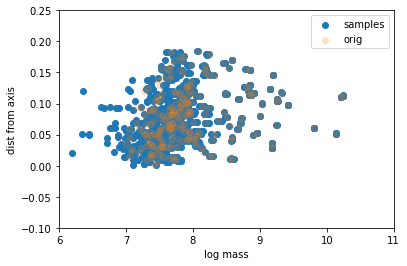

In [308]:
values = np.vstack([subs['Mvir'],rs])
kernel = st.gaussian_kde(values,0.005)
m,r = kernel.resample(4*len(rs))
plt.scatter(np.log10(m),r,label='samples')
#plt.scatter(np.log10(mass_samps),rs,label='1d pdf')
plt.scatter(np.log10(subs['Mvir']),rs,alpha=0.2,label='orig')
plt.xlabel('log mass')
plt.ylabel('dist from axis')
plt.legend()
plt.xlim(6,11)
plt.ylim(-0.1,.25)
plt.show()


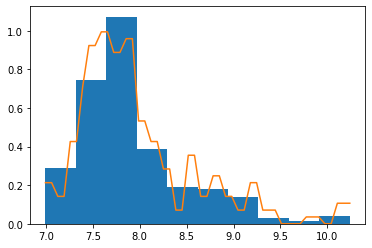

In [288]:
plt.hist(np.log10(subs['Mvir']),density=True)
mass_arr = np.log10(np.logspace(np.log10(min(subs['Mvir'])),np.log10(max(subs['Mvir'])),50))
plt.plot(mass_arr,get_mass_function(np.log10(subs['Mvir'])).pdf(mass_arr))
plt.show()

In [75]:
out_cut = np.argsort(np.log10(subs['Mvir']))[:-25]
p = np.polyfit(np.log10(subs['Mvir'])[out_cut],rs[out_cut], 1)  # Last argument is degree of polynomial
print("Coeeficient values:\n", p)
predict = np.poly1d(p)

Coeeficient values:
 [ 0.02924044 -0.14913184]


In [76]:
samps = get_samples(mass_arr,get_mass_function(np.log10(subs['Mvir'])).pdf(mass_arr),num_samples = 224)

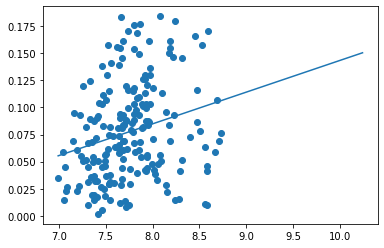

In [79]:
plt.scatter(np.log10(subs['Mvir'])[out_cut],rs[out_cut])
plt.plot(np.sort(samps),predict(np.sort(samps)))
plt.show()

In [112]:
m_bins = np.logspace(min(np.log10(subs['Mvir'])),max(np.log10(subs['Mvir'])),50)
r_bins = np.linspace(min(rs),max(rs),50)

hist = np.histogram2d(subs['Mvir'],rs,bins=(m_bins,r_bins))

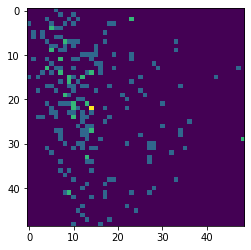

In [113]:
plt.imshow(hist[0].T)

In [117]:
import scipy.stats as st
from sklearn.datasets import make_blobs

In [148]:
# Define the borders
deltaX = (max(np.log10(subs['Mvir'])) - min(np.log10(subs['Mvir'])))/10
deltaY = (max(np.log10(rs)) - min(np.log10(rs)))/10
xmin = min(np.log10(subs['Mvir'])) - deltaX
xmax = max(np.log10(subs['Mvir'])) + deltaX
ymin = min(np.log10(rs)) - deltaY
ymax = max(np.log10(rs)) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

6.669845675102355 10.562975361552144 -2.9233970338872615 -0.5365672450387116


In [149]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([np.log10(subs['Mvir']),np.log10(rs)])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

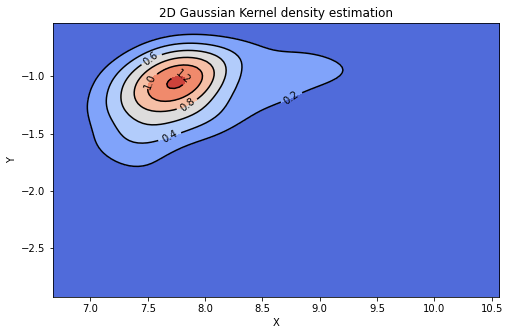

In [150]:
fig = plt.figure(figsize=(8,8))

ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
ax.set_aspect('equal')
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')
ax.set_aspect('equal', adjustable='box')

In [153]:
kernel.resample(10)

array([[ 7.23798284,  7.75412806,  9.15807754,  7.92222911,  7.41531167,
         8.61251148,  7.61209775,  7.68179604, 10.30859549,  7.48968338],
       [-1.26739375, -1.51890747, -1.11852631, -1.47775342, -1.47575031,
        -1.97149917, -1.97760745, -0.99717167, -0.89285643, -0.9037256 ]])